In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Flatten, Dropout, InputLayer
from keras.optimizers import Adam, Adamax, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Import data from Google Drive 

In [0]:
# __import__('google.colab.files', fromlist=[None]).upload() # too slow to upload
# __import__('google.colab.drive', fromlist=[None]).mount('/content/gdrive') # mount the entire drive

!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1D7NEp6r4LslueEGRWrTDVE7s_61i2RW3'})
download.GetContentFile('data_img.zip')

!unzip -qq data_img.zip

del auth, gauth, drive, download

__import__('IPython').display.clear_output()

In [0]:
# move the files into their respective dirs: train, val, test
import os

for i in ['train/a', 'train/b', 'val/a', 'val/b', 'test/a', 'test/b']: os.makedirs(i, exist_ok=True)

def tmp(x):
    files = os.listdir(x)
    indexes = np.random.permutation(len(files))
    indexes_train = indexes[:round(len(indexes) * 0.6)]
    indexes_val = indexes[round(len(indexes) * 0.6):round(len(indexes) * 0.8)]
    indexes_test = indexes[round(len(indexes) * 0.8):]
    for i in indexes_train:
        file = files[i]
        os.rename(x + '/' + file, 'train/' + x + '/' + file)
    for i in indexes_val:
        file = files[i]
        os.rename(x + '/' + file, 'val/' + x + '/' + file)
    for i in indexes_test:
        file = files[i]
        os.rename(x + '/' + file, 'test/' + x + '/' + file)

np.random.seed(0)       
tmp('a')
tmp('b')

del os, tmp

In [0]:
h = 135
w = 240

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(h, w, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rescale=1./255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.05,
    horizontal_flip=True,
#     shear_range=0.2,
    zoom_range=0.2,
)

opts = {
    'target_size': (h, w),
    'batch_size': 256,
    'class_mode': 'binary',
    'color_mode': 'grayscale',
    'seed': 0,
}
train_generator = datagen.flow_from_directory('train', **opts)
val_generator = datagen.flow_from_directory('val', **opts)


hist = model.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=val_generator,
    validation_steps=40
)


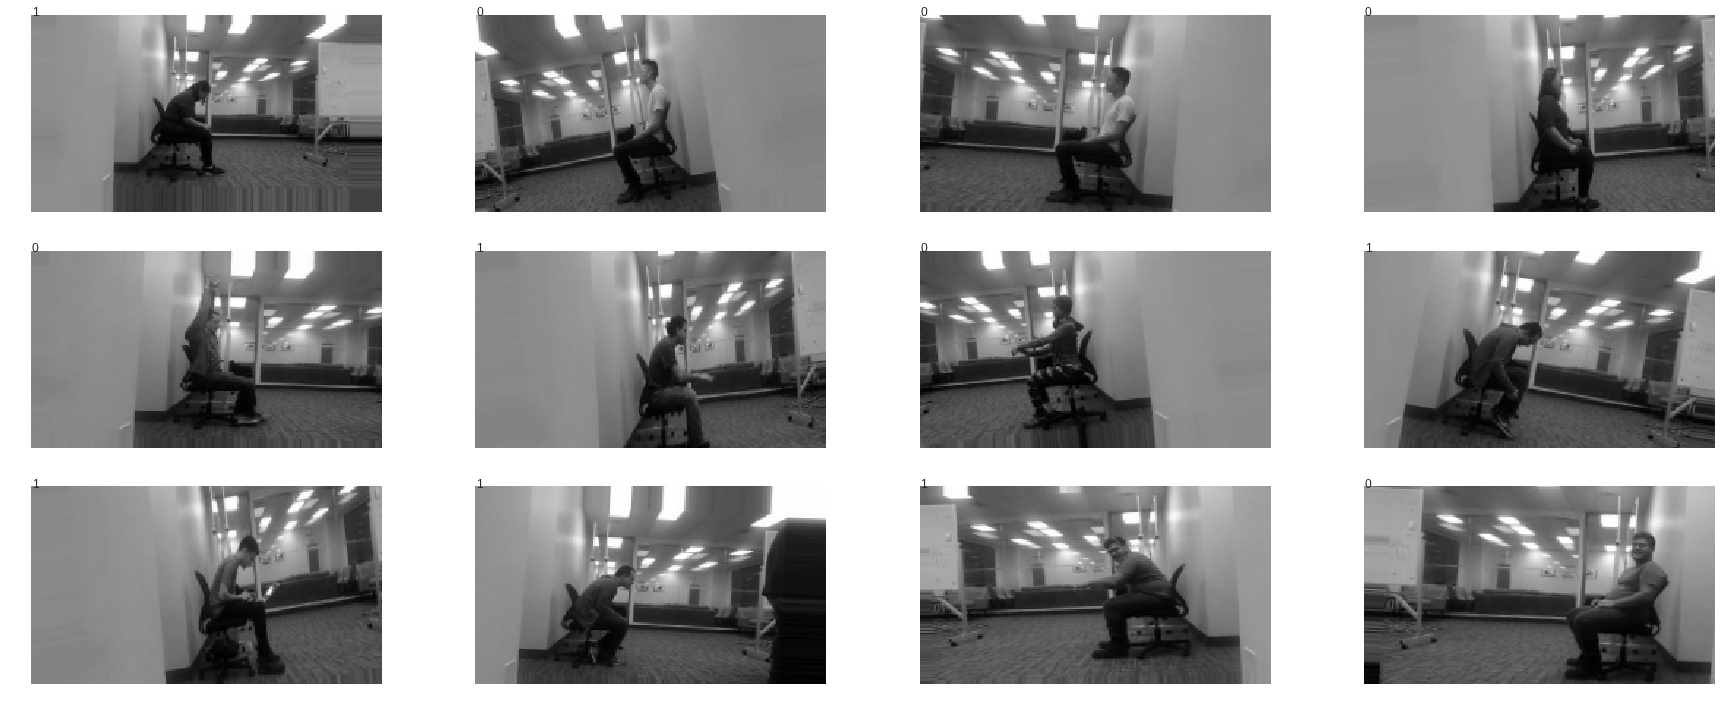

In [50]:
# draw some random imgs

plt.figure(figsize=(25, 10))

imgs = next(train_generator)
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(imgs[0][i].reshape(135, 240), cmap='gray')
    plt.annotate(int(imgs[1][i]), (0, 0))
    plt.axis('off')
    plt.grid(False)
    
plt.tight_layout()

del imgs